# COVID-19 and CA hospitals

### Load python tools

In [1]:
import pandas as pd
import geopandas as gpd
import jenkspy
import matplotlib.pyplot as plt
%matplotlib inline
import json
import numpy as np
from altair import datum
import altair as alt
import altair_latimes as lat
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000
alt.data_transformers.disable_max_rows()
from selenium import webdriver
driver = webdriver.Chrome(executable_path='/Users/mhustiles/Desktop/chromedriver')

### Hospital building characteristics

In [2]:
#https://data.chhs.ca.gov/dataset/hospital-building-data
#Metadata: https://data.chhs.ca.gov/dataset/hospital-building-data/resource/cefc10e5-5071-4ca4-8b03-2249caf0d294
buildings = pd.read_csv('input/ca-oshpd-gachospital-building-03052020.csv', encoding='Latin-1',\
                        dtype={'year_completed': object, 'building_code_year': object, 'stories': int,\
                               'height_ft': int}).fillna('')

In [3]:
buildings.columns = buildings.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

In [4]:
buildings.head()

,county_code,perm_id,facility_name,city,building_nbr,building_name,building_status,spc_rating_*,building_url,height_ft,stories,building_code,building_code_year,year_completed,latitude,longitude,count
0,01 - Alameda,11210,Alameda Hospital,Alameda,BLD-01278,Original Hospital,In Service,1,https://eserv.oshpd.ca.gov/CitizenAccess/Cap/C...,44.17,4,Unknown,,1926,37.762657,-122.253899,1
1,01 - Alameda,11210,Alameda Hospital,Alameda,BLD-01279,Stephens Wing,In Service,1,https://eserv.oshpd.ca.gov/CitizenAccess/Cap/C...,35,3,1952 Uniform Building Code (UBC),1952,1956,37.762657,-122.253899,1
2,01 - Alameda,11210,Alameda Hospital,Alameda,BLD-01280,West Wing,In Service,2,https://eserv.oshpd.ca.gov/CitizenAccess/Cap/C...,,2,1964 Uniform Building Code (UBC),1964,1968,37.762657,-122.253899,1
3,01 - Alameda,11210,Alameda Hospital,Alameda,BLD-01281,South Wing,In Service,3s,https://eserv.oshpd.ca.gov/CitizenAccess/Cap/C...,,3,1976 California Building Code (CBC),1976,1983,37.762657,-122.253899,1
4,01 - Alameda,11210,Alameda Hospital,Alameda,BLD-01282,Radiology Addition,In Service,5s,https://eserv.oshpd.ca.gov/CitizenAccess/Cap/C...,,2,1985 California Building Code (CBC),1985,1995,37.762657,-122.253899,1


In [5]:
buildings_geo = gpd.GeoDataFrame(
    buildings, geometry=gpd.points_from_xy(buildings.longitude, buildings.latitude))

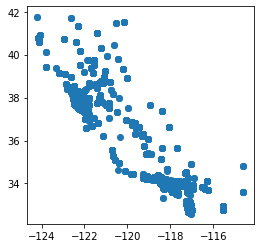

In [6]:
buildings_geo.plot()

--- 

### Facility listing

In [7]:
#https://data.chhs.ca.gov/dataset/healthcare-facility-locations/resource/0a0476ba-442c-40ff-97dc-dc840fa7e907
facilities = pd.read_excel('input/healthcare_facility_locations.xlsx')

In [8]:
facilities.columns = facilities.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

In [9]:
facilities_geo = gpd.GeoDataFrame(
    facilities, geometry=gpd.points_from_xy(facilities.longitude, facilities.latitude))

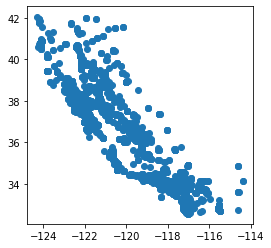

In [10]:
facilities_geo.plot()

In [11]:
hospitals = facilities_geo[facilities_geo['fac_type_code'] == 'GACH']

In [12]:
hospitals['entity_type_description'].value_counts()

NONPROFIT CORP               215
LIMITED LIABILITY COMPANY     65
PROFIT CORP                   49
HEALTH CARE DISTRICT          34
PARTNERSHIP                   19
COUNTY                        17
UC REGENT                      9
OTHER PUBLIC AGENCY            5
INDIVIDUAL                     1
STATE AGENCY                   1
CITY                           1
Name: entity_type_description, dtype: int64

In [13]:
hospitals.head()

,facid,npi,facname,fac_type_code,fac_fdr,ltc,capacity,address,city,zip,zip9,facadmin,contact_email,contact_fax,contact_phone_number,county_code,county_name,district_number,district_name,isfacmain,license_number,business_name,initial_license_date,license_effective_date,license_expiration_date,entity_type_description,latitude,longitude,location,oshpd_id,streetnum,streetname,cclho_code,cclho_name,fips_county_code,birthing_facility_flag,trauma_ped_ctr,trauma_ctr,type_of_care,critical_access_hospital,geometry
243,30000037,1467560599,METHODIST HOSPITAL OF SACRAMENTO,GACH,GENERAL ACUTE CARE HOSPITAL,NON-LTC,158,7500 HOSPITAL DRIVE,SACRAMENTO,95823,5403.0,"BALTZ, PHYLLIS A",MARI.SHELTON@DIGNITYHEALTH.ORG,(916) 423-6045,(916) 423-3000,440,SACRAMENTO,3,SACRAMENTO,Y,30000064.0,DIGNITY COMMUNITY CARE,1980-06-30,2019-12-31,2020-12-30,NONPROFIT CORP,38.463530,-121.416061,"(-121.416061,38.46353)",106340951.0,7500,HOSPITAL DRIVE,34,SACRAMENTO,6067,YES,NaN,NaN,NaN,NaN,POINT (-121.41606 38.46353)
261,30000108,1447494323,SUTTER AMADOR HOSPITAL,GACH,GENERAL ACUTE CARE HOSPITAL,NON-LTC,52,200 MISSION BOULEVARD,JACKSON,95642,2564.0,"DICKSON, THOMAS",SAMMOND@SUTTERHEALTH.ORG,(209) 223-7454,(209) 223-7500,20,AMADOR,3,SACRAMENTO,Y,30000008.0,SUTTER VALLEY HOSPITALS,1979-05-01,2019-11-01,2020-10-31,NONPROFIT CORP,38.350190,-120.764621,"(-120.764621,38.35019)",106034002.0,200,MISSION BOULEVARD,3,AMADOR,6005,YES,NaN,NaN,NaN,NaN,POINT (-120.76462 38.35019)
262,30000109,1194774299,SUTTER AUBURN FAITH HOSPITAL,GACH,GENERAL ACUTE CARE HOSPITAL,NON-LTC,64,11815 EDUCATION STREET,AUBURN,95602,2410.0,"HANNA, MITCHELL J",ZOBELC@SUTTERHEALTH.ORG,(530) 886-6611,(530) 888-4557,410,PLACER,3,SACRAMENTO,Y,30000012.0,SUTTER VALLEY HOSPITALS,1966-06-30,2019-07-26,2020-05-30,NONPROFIT CORP,38.945570,-121.100331,"(-121.100331,38.94557)",106310791.0,11815,EDUCATION STREET,31,PLACER,6061,NaN,NaN,NaN,NaN,NaN,POINT (-121.10033 38.94557)
263,30000113,1710918545,UNIVERSITY OF CALIFORNIA DAVIS MEDICAL CENTER,GACH,GENERAL ACUTE CARE HOSPITAL,NON-LTC,625,2315 STOCKTON BOULEVARD,SACRAMENTO,95817,2201.0,"SIMMONS, BRADLEY",LTNAVARRA@UCDAVIS.EDU,(916) 734-3234,(916) 734-2011,440,SACRAMENTO,3,SACRAMENTO,Y,30000086.0,UNIVERSITY OF CALIFORNIA BOARD OF REGENTS,1953-08-26,2019-12-06,2020-04-07,UC REGENT,38.554290,-121.455181,"(-121.455181,38.55429)",106341006.0,2315,STOCKTON BOULEVARD,34,SACRAMENTO,6067,YES,LEVEL I PED,LEVEL I,NaN,NaN,POINT (-121.45518 38.55429)
264,30000114,1003867565,BARTON MEMORIAL HOSPITAL,GACH,GENERAL ACUTE CARE HOSPITAL,NON-LTC,63,2170 SOUTH AVENUE,SOUTH LAKE TAHOE,96150,7025.0,"PURVANCE, CLINTON D",PUBLICRELATIONS@BARTONHEALTH.ORG,(530) 541-4697,(530) 541-3420,80,EL DORADO,3,SACRAMENTO,Y,30000013.0,BARTON HEALTHCARE SYSTEM,1963-11-21,2019-07-11,2020-06-29,NONPROFIT CORP,38.912319,-119.996583,"(-119.996583,38.912319)",106090793.0,2170,SOUTH AVENUE,9,EL DORADO,6017,YES,NaN,LEVEL III,NaN,NaN,POINT (-119.99658 38.91232)


In [14]:
public_list = ['COUNTY','UC REGENT','OTHER PUBLIC AGENCY','CITY','STATE AGENCY']

In [15]:
public = hospitals[hospitals['entity_type_description'].isin(public_list)]

In [16]:
public.to_csv('output/public_hospitals_from_chhs.csv')

In [17]:
public.contact_email.tolist()

['LTNAVARRA@UCDAVIS.EDU',
 'INFO@SJGH.ORG',
 nan,
 'DFINLEY@DHS.LACOUNTY.GOV',
 'LZMARTINEZ@DHS.LACOUNTY.GOV',
 nan,
 'DCASTILLO@DHS.LACOUNTY.GOV',
 'DBOURGET@UCI.EDU',
 'LICENSINGANDCERTIFICATION@NATIVIDAD.COM',
 'PATRYAN@VERITY.ORG',
 'HOSPITAL.ADMIN@HHS.SCCGOV.ORG',
 'CORRIERUDD@VERIFY.ORG',
 'ADOLPHE.EDWARD@ECRMC.ORG',
 'POLSEN@UCSD.EDU',
 nan,
 'RON.EYRAUD@KERNMEDICAL.COM',
 'RISKMANAGEMENT@ALAMEDAHEALTHSYSTEM.ORG',
 nan,
 'ADALY@ACMEDCTR.ORG',
 'JASPREET.BENEPAL@CCHEALTH.ORG',
 nan,
 'CKUNNAPPILLY@SMCGOV.ORG',
 nan,
 nan,
 nan,
 nan,
 'HOGGANE@ARMC.SBCOUNTY.GOV',
 nan,
 nan,
 'JAJACKSON@ACMEDCTR.ORG',
 nan,
 'PWATKINS@MEDNET.UCLA.EDU',
 'MBWILLIS@MEDNET.UCLA.EDU']

In [18]:
len(public)

33

In [19]:
public.head()

,facid,npi,facname,fac_type_code,fac_fdr,ltc,capacity,address,city,zip,zip9,facadmin,contact_email,contact_fax,contact_phone_number,county_code,county_name,district_number,district_name,isfacmain,license_number,business_name,initial_license_date,license_effective_date,license_expiration_date,entity_type_description,latitude,longitude,location,oshpd_id,streetnum,streetname,cclho_code,cclho_name,fips_county_code,birthing_facility_flag,trauma_ped_ctr,trauma_ctr,type_of_care,critical_access_hospital,geometry
263,30000113,1710918545,UNIVERSITY OF CALIFORNIA DAVIS MEDICAL CENTER,GACH,GENERAL ACUTE CARE HOSPITAL,NON-LTC,625,2315 STOCKTON BOULEVARD,SACRAMENTO,95817,2201.0,"SIMMONS, BRADLEY",LTNAVARRA@UCDAVIS.EDU,(916) 734-3234,(916) 734-2011,440,SACRAMENTO,3,SACRAMENTO,Y,30000086.0,UNIVERSITY OF CALIFORNIA BOARD OF REGENTS,1953-08-26,2019-12-06,2020-04-07,UC REGENT,38.554290,-121.455181,"(-121.455181,38.55429)",106341006.0,2315,STOCKTON BOULEVARD,34,SACRAMENTO,6067,YES,LEVEL I PED,LEVEL I,NaN,NaN,POINT (-121.45518 38.55429)
279,30000135,1275605180,SAN JOAQUIN GENERAL HOSPITAL,GACH,GENERAL ACUTE CARE HOSPITAL,NON-LTC,152,500 W. HOSPITAL ROAD,FRENCH CAMP,95231,9693.0,"CULBERSON, DAVID",INFO@SJGH.ORG,(209) 468-7011,(209) 468-6000,490,SAN JOAQUIN,3,SACRAMENTO,Y,30000087.0,COUNTY OF SAN JOAQUIN,1953-07-01,2020-01-01,2020-10-31,COUNTY,37.886550,-121.282211,"(-121.282211,37.88655)",106391010.0,500,W. HOSPITAL ROAD,39,SAN JOAQUIN,6077,YES,NaN,LEVEL III,NaN,NaN,POINT (-121.28221 37.88655)
698,50000039,1629167457,VENTURA COUNTY MEDICAL CENTER,GACH,GENERAL ACUTE CARE HOSPITAL,NON-LTC,180,300 HILLMONT AVE,VENTURA,93003,3099.0,"FANKHAUSER, JOHN",NaN,(805) 652-6169,(805) 652-6075,660,VENTURA,5,VENTURA,Y,50000032.0,COUNTY OF VENTURA,1953-07-01,2020-03-01,2021-02-28,COUNTY,34.279145,-119.254337,"(-119.254337,34.279145)",106560481.0,300,HILLMONT AVE,56,VENTURA,6111,YES,NaN,LEVEL II,NaN,NaN,POINT (-119.25434 34.27914)
918,60000027,1295757938,LAC/HARBOR UCLA MEDICAL CENTER,GACH,GENERAL ACUTE CARE HOSPITAL,NON-LTC,415,1000 W CARSON ST,TORRANCE,90502,2004.0,"MCKENZIE, KIMBERLY",DFINLEY@DHS.LACOUNTY.GOV,(310) 328-9624,(310) 222-2345,200,LOS ANGELES,6,ORANGE,Y,60000129.0,LOS ANGELES COUNTY DEPARTMENT OF HEALTH SERVICES,1953-07-01,2019-05-01,2020-04-30,COUNTY,33.831540,-118.294551,"(-118.294551,33.83154)",106191227.0,1000,W CARSON ST,19,LOS ANGELES,6037,YES,LEVEL II PED,LEVEL I,NaN,NaN,POINT (-118.29455 33.83154)
919,60000028,1336156363,LAC/RANCHO LOS AMIGOS NATIONAL REHABILITATION ...,GACH,GENERAL ACUTE CARE HOSPITAL,NON-LTC,158,7601 IMPERIAL HWY,DOWNEY,90242,3456.0,"OROZCO, JORGE",LZMARTINEZ@DHS.LACOUNTY.GOV,(562) 803-0056,(562) 385-7022,200,LOS ANGELES,6,ORANGE,Y,60000161.0,LOS ANGELES COUNTY DEPARTMENT OF HEALTH SERVICES,1953-07-01,2020-01-23,2020-03-30,COUNTY,33.929100,-118.158001,"(-118.158001,33.9291)",106191306.0,7601,IMPERIAL HWY,19,LOS ANGELES,6037,NaN,NaN,NaN,NaN,NaN,POINT (-118.15800 33.92910)


---

### Johns Hopkins data

In [20]:
# Cases: 
# https://services1.arcgis.com/0MSEUqKaxRlEPj5g/ArcGIS/rest/services/Coronavirus_2019_nCoV_Cases/FeatureServer/1

# Deaths: 
# https://services1.arcgis.com/0MSEUqKaxRlEPj5g/ArcGIS/rest/services/Coronavirus_2019_nCoV_Cases/FeatureServer/0

# Cases countries: 
# https://services1.arcgis.com/0MSEUqKaxRlEPj5g/ArcGIS/rest/services/Coronavirus_2019_nCoV_Cases/FeatureServer/2

# Cases/time: 
# https://services1.arcgis.com/0MSEUqKaxRlEPj5g/ArcGIS/rest/services/cases_time_v3/FeatureServer/0

---

### CHHS: Hospital Annual Utilization Report - 2018

In [21]:
# https://data.chhs.ca.gov/dataset/hospital-annual-utilization-report
# pivot table: https://data.chhs.ca.gov/dataset/hospital-annual-utilization-report/resource/4ee65e8c-ca6e-42d3-9aec-adcc56383856

In [22]:
utilization = pd.read_excel('input/hosp19_util_data_final.xlsx', sheet_name='Page 1-6')

In [23]:
utilization.columns = utilization.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

In [76]:
utilization.iloc[0]

description                                                                                              NaN
fac_no                                                                                             106010735
fac_name                                                                                    ALAMEDA HOSPITAL
fac_str_addr                                                                                2070 CLINTON AVE
fac_city                                                                                             ALAMEDA
fac_zip                                                                                                94501
fac_phone                                                                                       510-522-3700
fac_admin_name                                                                                  Luis Fonseca
fac_operated_this_yr                                                                                     Yes
fac_op_per_begin_dt

In [69]:
utilization.rename(columns={"ic_cen_days": "icu_days", "ic_lic_bed_days": "icu_bed_days",\
                     'ic_lic_beds':'icu_beds'}, inplace=True)

In [75]:
utilization[['fac_no', 'fac_name', 'fac_city', 'county', 'license_no', 'fac_zip', 'icu_beds', 'tot_lic_beds']].to_csv('output/hospital_utilization.csv', index=False)

In [71]:
utilization['icu_occupancy_rate'] = ((utilization.icu_days / utilization.icu_bed_days)*100).round()

In [72]:
utilization_geo = gpd.GeoDataFrame(
    utilization, geometry=gpd.points_from_xy(utilization.longitude, utilization.latitude))

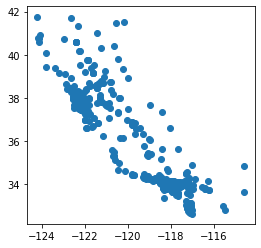

In [73]:
utilization_geo.plot()

In [30]:
utilization_counties = utilization_geo.groupby(['county']).agg({'icu_days':'sum', 'icu_bed_days':'sum', \
                                                  'icu_beds':'sum', 'icu_occupancy_rate':'mean'}).reset_index()

In [31]:
utilization_counties.sort_values(by='icu_beds', ascending=False).head()

,county,icu_days,icu_bed_days,icu_beds,icu_occupancy_rate
17,Los Angeles,461347.0,765503,2109,65.174419
28,Orange,131000.0,227237,622,59.206897
35,San Diego,123108.0,216725,580,56.000000
34,San Bernardino,132084.0,181040,496,80.350000
36,San Francisco,68544.0,125184,381,53.166667


In [32]:
utilization_counties.fillna('').to_csv('output/icu_by_county.csv')

In [33]:
icus = utilization_geo[utilization_geo['icu_beds'] > 0]
icus_slim = icus[[ 'fac_name', 'county', 'icu_beds','icu_days', \
                  'icu_bed_days', 'icu_occupancy_rate', 'geometry' ]]

In [34]:
icus_slim.sort_values(by='icu_beds', ascending=False).head()

,fac_name,county,icu_beds,icu_days,icu_bed_days,icu_occupancy_rate,geometry
184,LAC+USC MEDICAL CENTER,Los Angeles,130,29135.0,47450,61.0,POINT (-118.21031 34.05982)
151,CEDARS-SINAI MEDICAL CENTER,Los Angeles,126,32248.0,45990,70.0,POINT (-118.38061 34.07681)
171,RONALD REAGAN UCLA MEDICAL CENTER,Los Angeles,120,44345.0,43800,101.0,POINT (-118.44500 34.06889)
295,UNIVERSITY OF CALIFORNIA DAVIS MEDICAL CENTER,Sacramento,116,32532.0,42340,77.0,POINT (-121.45738 38.55438)
410,STANFORD HEALTH CARE,Santa Clara,104,2347.0,5720,41.0,POINT (-122.17657 37.43384)


In [35]:
len(icus)

345

In [62]:
icus_slim.to_file('output/icus.geojson', driver='GeoJSON')

In [63]:
icus_slim.sort_values(by='icu_beds', ascending=False).head()

,fac_name,county,icu_beds,icu_days,icu_bed_days,icu_occupancy_rate,geometry
184,LAC+USC MEDICAL CENTER,Los Angeles,130,29135.0,47450,61.0,POINT (-118.21031 34.05982)
151,CEDARS-SINAI MEDICAL CENTER,Los Angeles,126,32248.0,45990,70.0,POINT (-118.38061 34.07681)
171,RONALD REAGAN UCLA MEDICAL CENTER,Los Angeles,120,44345.0,43800,101.0,POINT (-118.44500 34.06889)
295,UNIVERSITY OF CALIFORNIA DAVIS MEDICAL CENTER,Sacramento,116,32532.0,42340,77.0,POINT (-121.45738 38.55438)
410,STANFORD HEALTH CARE,Santa Clara,104,2347.0,5720,41.0,POINT (-122.17657 37.43384)


In [65]:
icus_slim.to_csv('output/icu_by_facility_nu.csv', index=False)

### ICU bed rate per 100,000 residents

In [39]:
# basically one bed for every 5,350 residents not counting 50% occupancy rate already
(icus_slim.icu_beds.sum()*100000) / 39512223

18.657517700282266

### ICU bed rate per 100,000 residents older than 65 (5.6 million in CA)

In [40]:
# basically one bed for every 37,500 residents over 65 not counting 50% occupancy rate already
(icus_slim.icu_beds.sum()*100000) / (39512223/0.143)

2.6680250311403633

--- 

In [41]:
county_pop = pd.read_csv('input/processed/acs5_2018_population_counties.csv',\
                        dtype={'geoid':'object', 'state':'object', 'county':'object'})

In [42]:
ca_counties = pd.DataFrame(county_pop[county_pop['state'] == '06'])

In [43]:
ca_counties.drop(columns=['universe_annotation', 'universe_moe', 'universe_moe_annotation'], inplace=True)
ca_counties.rename(columns={"universe": "population"}, inplace=True)

In [44]:
ca_counties['county'] = ca_counties['name'].str.replace(' County, California', '')

In [45]:
ca_counties.head()

,geoid,name,population,state,county
181,06001,"Alameda County, California",1643700.0,06,Alameda
182,06005,"Amador County, California",37829.0,06,Amador
183,06007,"Butte County, California",227075.0,06,Butte
184,06009,"Calaveras County, California",45235.0,06,Calaveras
185,06011,"Colusa County, California",21464.0,06,Colusa


In [46]:
icus_county_pop = utilization_counties.merge(ca_counties, on='county')

In [47]:
bayarea = ['Alameda', 'Marin', 'Contra Costa', 'San Mateo', 'Santa Clara', 'San Francisco']

In [48]:
bayarea_counties = icus_county_pop[icus_county_pop['county'].isin(bayarea)]
bayarea_counties.population.sum()

6595421.0

In [49]:
bayarea_counties.head(6)

,county,icu_days,icu_bed_days,icu_beds,icu_occupancy_rate,geoid,name,population,state
0,Alameda,56877.0,94400,256,67.800000,06001,"Alameda County, California",1643700.0,06
5,Contra Costa,39346.0,61685,169,65.750000,06013,"Contra Costa County, California",1133247.0,06
19,Marin,7016.0,10950,30,67.333333,06041,"Marin County, California",260295.0,06
36,San Francisco,68544.0,125184,381,53.166667,06075,"San Francisco County, California",870044.0,06
39,San Mateo,18016.0,35040,96,51.000000,06081,"San Mateo County, California",765935.0,06
41,Santa Clara,79598.0,116850,366,65.636364,06085,"Santa Clara County, California",1922200.0,06


In [50]:
icus_county_pop.head()

,county,icu_days,icu_bed_days,icu_beds,icu_occupancy_rate,geoid,name,population,state
0,Alameda,56877.0,94400,256,67.8,06001,"Alameda County, California",1643700.0,06
1,Amador,1291.0,2190,6,59.0,06005,"Amador County, California",37829.0,06
2,Butte,8593.0,17155,47,52.0,06007,"Butte County, California",227075.0,06
3,Calaveras,597.0,2920,8,20.0,06009,"Calaveras County, California",45235.0,06
4,Colusa,18.0,2190,6,1.0,06011,"Colusa County, California",21464.0,06


In [51]:
icus_county_pop['icus_per1000'] = (icus_county_pop['icu_beds'] * 100000) / icus_county_pop['population']

In [52]:
icus_county_pop.sort_values(by='icus_per1000', ascending=False).head()

,county,icu_days,icu_bed_days,icu_beds,icu_occupancy_rate,geoid,name,population,state,icus_per1000
36,San Francisco,68544.0,125184,381,53.166667,06075,"San Francisco County, California",870044.0,06,43.790889
43,Shasta,11857.0,25613,70,47.000000,06089,"Shasta County, California",179085.0,06,39.087584
26,Napa,5576.0,17520,48,41.000000,06055,"Napa County, California",140530.0,06,34.156408
18,Madera,10684.0,18980,52,62.000000,06039,"Madera County, California",155013.0,06,33.545574
55,Yuba,6380.0,8760,24,73.000000,06115,"Yuba County, California",75493.0,06,31.791027


In [53]:
icus_county_pop_slim = icus_county_pop[[ 'county', 'icu_beds', 'icus_per1000']]

In [54]:
icus_county_pop_slim.to_csv('output/icus_county_pop_slim.csv')

---

In [55]:
counties_geo = gpd.read_file('/Users/mhustiles/data/data/GIS/LA/counties/2012/counties.shp')

In [56]:
counties_geo.rename(columns={"fips": "geoid"}, inplace=True)

In [57]:
counties_geo = counties_geo.to_crs({'init': 'epsg:4326'})

/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [58]:
counties_geo.columns = counties_geo.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

In [59]:
counties_geo_slim = counties_geo[[ 'geoid', 'name', 'geometry']]

KeyError: "['geoid'] not in index"

In [ ]:
icus_geo = counties_geo_slim.merge(icus_county_pop, on='geoid')

In [ ]:
icus_geo.to_file('output/icus_geo.geojson', driver='GeoJSON')

In [ ]:
# !tippecanoe --generate-ids --force -r1 -pk -pf -o \
# output/icus_geo.mbtiles \
# output/icus_geo.geojson